# Tuning Confidence Score of Flight Call Detections
_Ashley Huang, Carlene English_, _Benjamin Van Doren_

In [452]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, precision_recall_curve
from scipy.stats import gaussian_kde
from scipy.special import logit
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import suncalc
import os
for path in ['exports', 'exports/csv', 'exports/figures']:
    if not os.path.exists(path):
        os.makedirs(path)

In [461]:
taxon = 'greyel'

common_names = {
    'greyel': 'Greater Yellowlegs', 
    'semplo': 'Semipalmated Plover', 
    'lobcur': 'Long-billed Curlew', 
    'uplsan': 'Upland Sandpiper', 
    'baisan': 'Baird\'s Sandpiper', 
    'wilsni': 'Wilson\'s Snipe', 
    'leasan': 'Least Sandpiper'
}

## 1. Plot the distribution of confidence scores
To avoid confusion for the term ***reviewed***, we will be using ***correct*** and ***incorrect*** when refering to review status.

`reviewStatus: Reviewed` -> ***Correct***

`reviewStatus: Problem` -> ***Incorrect***

***Correct*** or ***Incorrect*** -> ***Reviewed***

`reviewStatus: Unreviewed` -> ***Unreviewed***

reviewStatusRenamed
Unreviewed    1255
Correct         67
Incorrect       48
Name: count, dtype: int64

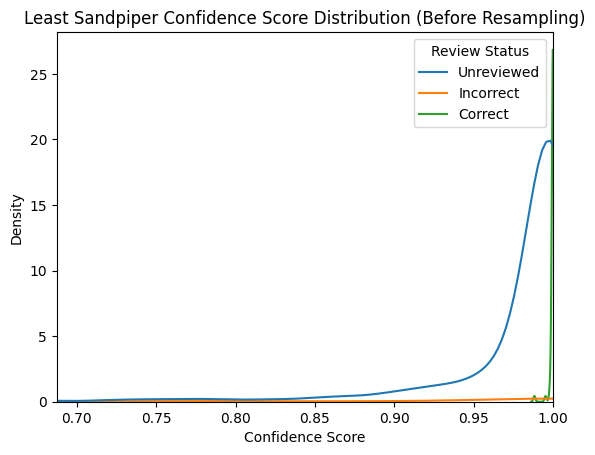

In [454]:
if taxon == 'uplsan':
    df_flood = pd.read_csv(f'detections/uplsan_flood.csv')
    df_correct = pd.read_csv(f'detections/uplsan_correct.csv')
    df_incorrect = pd.read_csv(f'detections/uplsan_incorrect.csv')
    df = pd.concat([df_flood, df_correct, df_incorrect])
else:
    df = pd.read_csv(f'detections/{taxon}.csv')

df['reviewStatusRenamed'] = df['reviewStatus'].map({'Reviewed': 'Correct', 
                                                    'Problem': 'Incorrect', 
                                                    'Unreviewed': 'Unreviewed'})

ax = sns.kdeplot(df, x='confidenceScore', hue='reviewStatusRenamed')
ax.get_legend().set_title('Review Status')
plt.title(f'{common_names[taxon]} Confidence Score Distribution (Before Resampling)')
plt.xlabel('Confidence Score')
plt.xlim(df['confidenceScore'].quantile(1e-2), 1)
plt.savefig(f'exports/figures/before_{taxon}.png')

df['reviewStatusRenamed'].value_counts()

## 2. Filter Out Daytime Detections
First, we filter out unreviewed detections and assign 0/1 to incorrect/correct detections. Then, we filter out daytime flight calls. Timestamps are compared to the sunset/sunrise time of MPG ranch. Once we obtained coordinated of each site, timestamp should be compared to the sunset/sunrise time of the corresponding site.

In [455]:
# Filter out unreviewed detections
df['reviewStatusBinary'] = df['reviewStatus'].map({'Reviewed': 1, 'Problem': 0, 'Unreviewed': -1})
df_reviewed = df[df['reviewStatusBinary'] >= 0]

# Filter by sunset and sunrise time
def get_sameday_dawn_dusk(utc_time, lon, lat):
    # Turns out Suncalc doesn't return the times of the same day. 
    # Instead, if the time has passed sunset, Suncalc returns the times of the next day.
    next_sunset = suncalc.get_times(utc_time, lon, lat)
    prev_sunset = suncalc.get_times(utc_time - timedelta(days=1), lon, lat)
    if (next_sunset['nautical_dawn'] - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date():
        utc_dawn, utc_dusk = next_sunset['nautical_dawn'], next_sunset['nautical_dusk']
    else:
        utc_dawn, utc_dusk = prev_sunset['nautical_dawn'], prev_sunset['nautical_dusk']
    assert((utc_dawn - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date())
    assert((utc_dusk - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date())
    return utc_dawn, utc_dusk

def is_nocturnal(time_str, dawn_offset=timedelta(minutes=0), dusk_offset=timedelta(minutes=0)):
    utc_time = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    utc_dawn, utc_dusk = get_sameday_dawn_dusk(utc_time, -116.3273099, 47.0559593)
    if utc_dawn + dawn_offset < utc_time < utc_dusk + dusk_offset:
        return False
    else:
        return True

total_detections = len(df_reviewed.index) * 1
df_reviewed = df_reviewed[df_reviewed['timestamp'].apply(is_nocturnal)]
print('nocturnal detections:', len(df_reviewed.index))
print('durinal detections:', total_detections - len(df_reviewed.index))

nocturnal detections: 47
durinal detections: 68


## 3. Resample Reviewed Detections to Match the Distribution of All Detections

In [456]:
scores = df['confidenceScore']
scores_reviewed = df_reviewed['confidenceScore']
kde = gaussian_kde(scores)
kde_reviewed = gaussian_kde(scores_reviewed)
weights = kde.evaluate(scores_reviewed) / kde_reviewed.evaluate(scores_reviewed)
weights /= weights.sum()

resampled_sample_size = len(df_reviewed)
indicies = np.random.choice(df_reviewed.index, size=resampled_sample_size, p=weights, replace=True)
df_resampled = df_reviewed.loc[indicies]
df_resampled.to_csv(f'exports/csv/{taxon}_resampled.csv', index=False) # save dataframe to exports/csv/

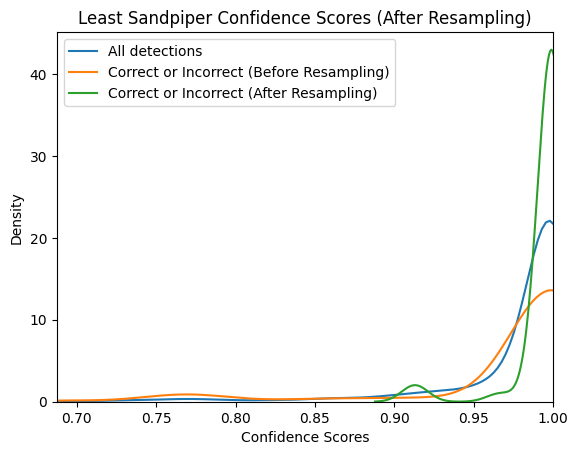

In [457]:
# Plot the distribution before and after resampling
sns.kdeplot(df['confidenceScore'], color='#1f77b4', label='All detections')
sns.kdeplot(df[df['reviewStatus'].isin(['Reviewed', 'Problem'])]['confidenceScore'].values, color='#ff7f0e', label='Correct or Incorrect (Before Resampling)')
sns.kdeplot(df_resampled['confidenceScore'], color='#2ca02c', label='Correct or Incorrect (After Resampling)')
plt.title(f'{common_names[taxon]} Confidence Scores (After Resampling)')
plt.xlabel('Confidence Scores')
plt.xlim(df['confidenceScore'].quantile(1e-2), 1)
plt.legend()

## 5. Fit with Logistic Regression

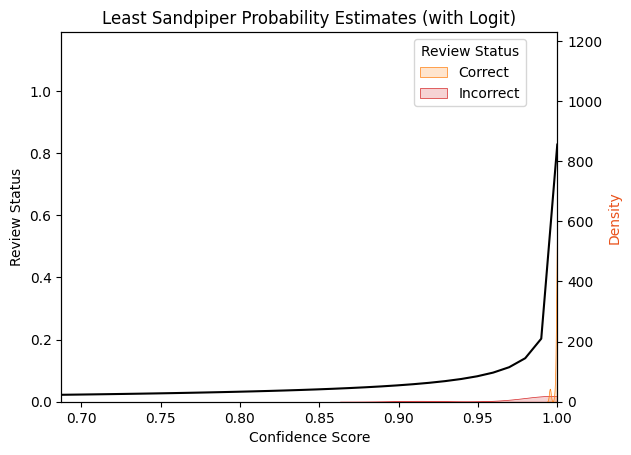

In [458]:
X = df_resampled['confidenceScore'].values.reshape(-1, 1)
y = df_resampled['reviewStatusBinary'].values
X_logit = logit(X.clip(1e-4, 1 - 1e-4)) # apply logit
logr = LogisticRegression()
logr.fit(X_logit, y)

# Predict y of x in [0, 1]
X = np.linspace(0, 1, 100).reshape(-1, 1)
X_logit = logit(X.clip(1e-4, 1 - 1e-4)) # apply logit
y_hat = logr.predict_proba(X_logit)[:, 1]

fig, ax1 = plt.subplots()
ax1.plot(X, y_hat, color='black')
ax1.set_xlim(df['confidenceScore'].quantile(1e-2), 1)
ax1.set_ylim(0, 1.19)
ax1.set_xlabel('Confidence Score')
ax1.set_ylabel('Review Status')
ax1.set_title(f'{common_names[taxon]} Probability Estimates (with Logit)')
plt.savefig(f'exports/figures/prob_{taxon}.png')

ax2 = ax1.twinx()
sns.kdeplot(data=df_resampled, x='confidenceScore', hue='reviewStatusRenamed', 
            fill=True, alpha=0.2, common_norm=False, palette=['#ff7f0e', '#d62728'], linewidth=0.5, 
            ax=ax2)
ax2.set_ylabel('Density', color='#ea521b')
ax2.set_ylim(0, ax2.get_ylim()[1] * 2) # Scale KDE by 1/2 to not clutter up the figure
ax2.get_legend().set_title('Review Status')
ax2.get_legend().set_bbox_to_anchor((0.95, 1))

plt.savefig(f'exports/figures/prob_w_dist_{taxon}.png')

At probability={target_probability}), 
-> Precision = 0.8125
-> Recall = 0.83871


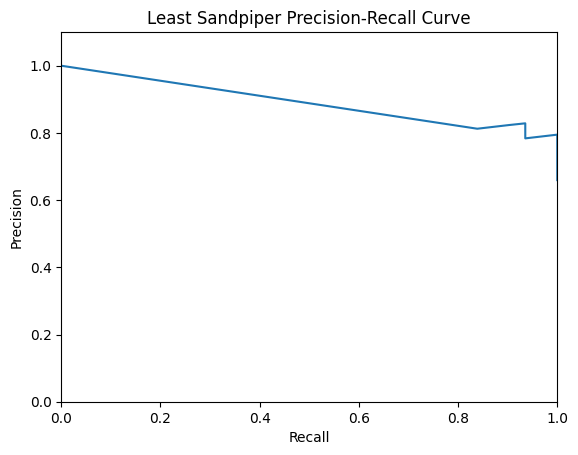

In [459]:
# Train logistic regression model
df_test = df_resampled.copy()
X = df_test['confidenceScore'].values.reshape(-1, 1)
y = df_test['reviewStatusBinary'].values
X_logit = logit(X.clip(1e-4, 1 - 1e-4)) # apply logit
y_hat = logr.predict_proba(X_logit)[:, 1]

precision, recall, threshold = precision_recall_curve(y, y_hat)
average_precision = average_precision_score(y, y_hat)
plt.plot(recall, precision)
plt.title(f'{common_names[taxon]} Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1.1)

# Find precision and recall at target probability
target_probability = 0.90
target_idx = np.argmin(np.abs(threshold - target_probability))
p_at_target = precision[target_idx]
r_at_target = recall[target_idx]
print('At probability={target_probability}), ')
print(f'-> Precision = {p_at_target.round(5)}')
print(f'-> Recall = {r_at_target.round(5)}')
# with open('exports/dump.txt', 'a') as dump:
    # dump.write(f'{p_at_target.round(5)}, {r_at_target.round(5)}\n')

/Users/ashley/Projects/nighthawk/.venv/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/ashley/Projects/nighthawk/.venv/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


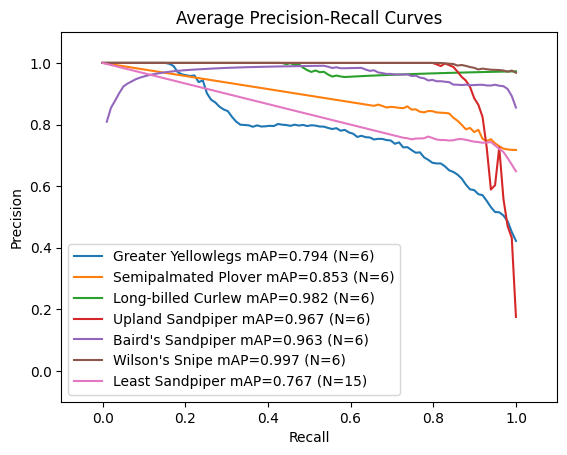

In [460]:
try:
    pr_curves[taxon].append((precision, recall))
    average_precisions[taxon].append(average_precision)
except KeyError:
    pr_curves[taxon] = [(precision, recall)]
    average_precisions[taxon] = [average_precision]
except NameError:
    pr_curves = {taxon: [(precision, recall)]}
    average_precisions = {taxon: [average_precision]}

# Plot average precision-recall curve
for t, pr_curve in pr_curves.items():
    recall_interp = np.linspace(0, 1, 100)
    precision_interp = list()
    for precision, recall in pr_curve:
        f = interp1d(recall, precision, kind='linear', bounds_error=False, fill_value='extrapolate')
        precision_interp.append(f(recall_interp))
        # plt.plot(recall, precision, alpha=0.2)
    mean_precision_interp = np.mean(precision_interp, axis=0)
    mean_average_precision = np.mean(average_precisions[t])
    plt.plot(recall_interp, mean_precision_interp, label=f'{common_names[t]} mAP={mean_average_precision.round(3)} (N={len(pr_curve)})')

plt.title('Average Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.savefig(f'exports/figures/average_pr_curves.png')